In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline

In [65]:
import nltk

In [23]:
Dir = 'C:/Users/farza/Downloads/Py_DS_ML_Bootcamp-master/Refactored_Py_DS_ML_Bootcamp-master/20-Natural-Language-Processing/smsspamcollection/SMSSpamCollection'

In [24]:
msg= [line.rstrip() for line in open(Dir)]

In [36]:
messages= pd.read_csv(Dir, sep='\t', names=['Label', 'Sms'])

In [47]:
messages.groupby('Label').describe().reset_index()

Label   Sms                                                               
        count unique                                                top freq
0   ham  4825   4516                             Sorry, I'll call later   30
1  spam   747    653  Please call our customer service representativ...    4

In [48]:
#Let us add a bew column that gives the length of each message
messages['Length']= messages['Sms'].apply(len)

array([<AxesSubplot:title={'center':'ham'}>,
       <AxesSubplot:title={'center':'spam'}>], dtype=object)

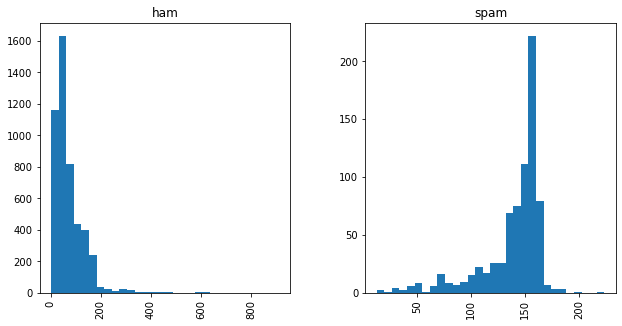

In [56]:
#Now we look at average length of spam and ham messages
messages.hist('Length', by='Label', figsize=(10, 5), bins=30)

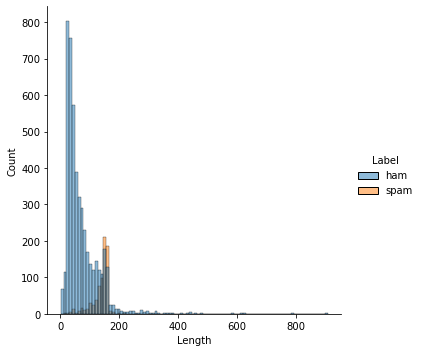

In [55]:
#We also look at the distribution: This shows that length of spam messages are close to 
#normal disribution with with the mean of 150 characters, and average length of ham messages is about 70
import seaborn as sns
sns.displot(data=messages, x='Length', hue='Label' )

In [62]:
#Let us look at this more closely
spam= messages[messages['Label']=='spam']
ham= messages[messages['Label']=='ham']

In [63]:
print('length_mean of spam =',spam['Length'].mean())
print('length_mean of ham =',ham['Length'].mean())

length_mean of spam = 138.6706827309237
length_mean of ham = 71.48248704663213


In [146]:
messages.head()

,Label,Sms,Length,Rate of SW
0,ham,"Go until jurong point, crazy.. Available only ...",111,0.200000
1,ham,Ok lar... Joking wif u oni...,29,0.000000
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,0.178571
3,ham,U dun say so early hor... U c already then say...,49,0.181818
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,0.384615


So far we can coclude that spam messages tend to be longer(almost twice in length) than ham messages. This can be a feature to be used in classification. 

In [71]:
from nltk.corpus import stopwords
stp_wrd_eng=stopwords.words('english')

In [100]:
#Here we define a function to give us the portion of stopwords used in each messages
def NofSW(s):
    stp=0
    for word in s.split(' '):
        if word in stp_wrd_eng:
            #print(word)
            stp+=1
    #print('length of s=', len(s.split(' ')))
    return stp/len(s.split(' '))        

In [103]:
# We add a column to record the ratio of stop words in message to total number of words in it. 
messages['Rate of SW']=messages['Sms'].apply(NofSW)

array([<AxesSubplot:title={'center':'ham'}>,
       <AxesSubplot:title={'center':'spam'}>], dtype=object)

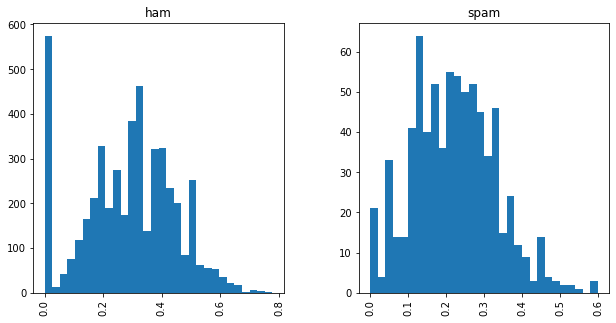

In [105]:
#Lets check if thi smake a diffrence between ham and spam 
messages.hist('Rate of SW', by='Label', figsize=(10, 5), bins=30)

ratio of stop words in spam = 0.22058798524857395
ratio of stop words in ham = 0.28510276056677725


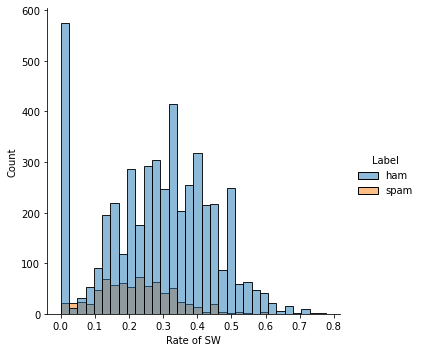

In [109]:
#We conclude that there are slightly more stop words in ham messages. 
sns.displot(data=messages, x='Rate of SW', hue='Label' )
spam= messages[messages['Label']=='spam']
ham= messages[messages['Label']=='ham']
print('ratio of stop words in spam =',spam['Rate of SW'].mean())
print('ratio of stop words in ham =',ham['Rate of SW'].mean())


In [120]:
#We also observe that there are many HAM messages without stop words, which indicates that many people when they write 
#a message avoid using stop words to perhaps abbreviate. 
print('Number of messages without stop words=', len(messages[messages['Rate of SW']==0]['Label']))
print('Ratio of spam messages without stop words=', len(spam[spam['Rate of SW']==0]['Label'])/len(spam['Label']))
print('Ratio of ham messages without stop words=', len(ham[ham['Rate of SW']==0]['Label'])/len(ham['Label']))

Number of messages without stop words= 596
Ratio of spam messages without stop words= 0.028112449799196786
Ratio of ham messages without stop words= 0.11917098445595854


Now we will clean up messages, with eliminating stop words and pnctuation:

In [130]:
import string
def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]


We start our work with sklearn:

In [149]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer


In [152]:
#For classification we use 
from sklearn.naive_bayes import MultinomialNB


In [153]:
#Lets split to test/train set
from sklearn.model_selection import train_test_split

msg_train, msg_test, label_train, label_test = \
train_test_split(messages['Sms'], messages['Label'], test_size=0.2)

print(len(msg_train), len(msg_test), len(msg_train) + len(msg_test))

4457 1115 5572


In [154]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [155]:
pipeline.fit(msg_train,label_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x0000024B64F74820>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

In [156]:
predictions = pipeline.predict(msg_test)

In [157]:
from sklearn.metrics import classification_report, confusion_matrix

We look at the calssification report to check our prediction accuracy. Note that 

$\textbf{Precision} = \frac{\text{True Positive}}{\text{True Positive}+ \text{False Positive}}$

$\textbf{Recall} = \frac{\text{True Positive}}{\text{True Positive}+ \text{False Negative}}$

The F1 is the weighted harmonic mean of precision and recall. The closer the value of the F1 score is to 1.0, the better the expected performance of the model is.

In [158]:
print(classification_report(predictions, label_test))

              precision    recall  f1-score   support

         ham       1.00      0.97      0.98      1018
        spam       0.74      1.00      0.85        97

    accuracy                           0.97      1115
   macro avg       0.87      0.98      0.92      1115
weighted avg       0.98      0.97      0.97      1115



Confusion matrix is 
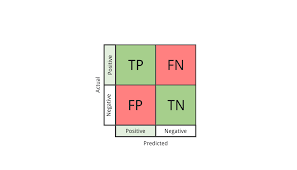

In [159]:
print(confusion_matrix(predictions, label_test))

[[984  34]
 [  0  97]]


In [193]:
#Lets us try one text message for example
tm1='Hi, how doing man, are u up for palying soccer tonight. We will go to the park cloe by'

s1= 'Dear customer, please come to our shop in St catherin street, we have 20% off on all items.' 
s2= 'Our sale starts 21st May 2005, you can win Free entry in 2 a wkly comp to FA Cup final tkts. Text FA to 87121 to win FA Cup final tkts 21st May 2005.'

tm2= s1+s2
tm2
#'Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&Cs apply 08452810075over18s'

#

'Dear customer, please come to our shop in St catherin street, we have 20% off on all items.Our sale starts 21st May 2005, you can win Free entry in 2 a wkly comp to FA Cup final tkts. Text FA to 87121 to win FA Cup final tkts 21st May 2005.'

In [194]:
pipeline.predict([tm1, tm2])

array(['ham', 'spam'], dtype='<U4')